## Теоретическая часть


**1.** Ответьте на вопросы:  
В чем принципиальное отличие гибридных рекомендательных систем от коллаборативной фильтрации?  
Приведите 2-3 примера задач, в которых необходимо использовать гибридные системы  

**Ответ:** основное отличие в том, что гибридная рекомендательная система учитывает не только данные из таблицы item-user взаимодействия, но также и фичи, которые характеризуют конкретных юзеров или товары.

Особенно полезно это для задач:
- решения проблемы "холодного старта" при появлении нового юзера, который не взаимодействовал ни с чем
- проблема "холодного старта" при запуске нового товара или направения
- как докрутка более простых baseline моделей
- когда в принципе мало данных о взаимодействиях item-user, т.е. матрица очень разряжена

Интересно, что LigthFM, как заявляют в научной работе по ней, хороша тем, что может работать как с очень разряженными матрицами user-item (LightFM работает лучше CF моделей), так и с матрицами с достаточным объемом данных (LightFM как минимум не хуже моделей CF).

**2.**  Прочитайте статью про поиск на hh.ru https://habr.com/ru/company/hh/blog/347276/
Нам интересна именно рекомендательная система, раздел "Производительность системы" можно пропустить
Какие основные отличия предложенной системы от тех подходов, которые мы разбирали на семинарах? Какие проблемы могут возникнуть при выводе такой модели в продакшен?

**Ответ:** основное отличие, что в их системе используется кэширование, т.е. как я понял заранее признаки вакансий и резюме считают. Во время запроса считают только парные признаки. Причем, чтобы снизить нагрузку считают только для актуальных юзеров - кто обновляет резюме и хоть что-то недавно искал. Также они изменили схему работы серверов для балансирования нагрузки. 

Мне понравилась идея использовать несколько фильтров перед непосредственным обсчетом финальной моделью. Это позволило снизить нагрузку от огромного кол-ва документов/фич и с помощью фильтров уменьшить число вариантов.

Основные проблемы - скорость подсчета самой модели, нагрузка на серверы в пиковые моменты, объем данных для хранения.

**3.** На вебинаре мы рассматривали модель LightFM (https://making.lyst.com/lightfm/docs/lightfm.html). В работе Data Scientist'а важную часть занимает research - исследование существующих архитектур и разбор научных статей, в которых они описываются. Вам предлагается изчуть оригинальную статью про LightFM https://arxiv.org/pdf/1507.08439.pdf и ответить на следующие вопросы:  
1) Какой датасет используют авторы?  
2) Что используют в качестве признаков?  
3) С какими моделями сравнивают LightFM? Опишите их основные идеи кратко  

**Ответ:**
1) всего 2 датасета: MovieLens - пример относительно плотного датасета с данными об интеракциях (где сильнее модели матричной факторизации) и CrossValidated - пример датасета с разряженными данными об интеракциях (где сильнее content-based модели)

2) для MovieLens доп. признаки - тэги к фильмам, для CrossValidated - данные юзеров из раздела "обо мне" в профиле

3) Модели для сравнения: а) MF - модель матричной факторизации с учетом смещения user и item (если правильно понял, это типа ALS); б) LSI-LR -  content-based модель основанная на технике Latent semantic analysis (Latent semantic indexing, LSI) с использованием логистической регрессии; в) LSI-UP - гибридная модель тоже на основе LSI; г) LightFM (tags) - LightFM с использованием только тэгов; д) LightFM (tags + ids) - LightFM с тэгами индикаторами item; е) LightFM (tags + about): LightFM использующая user и item фичи.

LightFM считает ROC AUC проводя 10 итераций рандомно разбивая на train и test 80/20 и затем находит среднее. Кстати, LightFM, расшифровывается как Factorization Machines. Написано было в статье =)

## Практическая часть


In [248]:
!pip install implicit

In [249]:
!pip install lightfm

In [250]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [251]:
import sys
sys.path.append(r'/content/drive/MyDrive/Colab Notebooks/recommender_systems/data')
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/Colab Notebooks/recommender_systems/data',
 '/',
 '/content/drive/MyDrive/Colab Notebooks/recommender_systems/data']

In [252]:
import pandas as pd
import numpy as np

import matplotlib as plt
import matplotlib.image as img
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams.update({'font.size': 14})
pd.set_option('display.max_columns', 500)

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings

warnings.filterwarnings('ignore')
    
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items

In [253]:
pr = lightfm.evaluation.precision_at_k

In [254]:
data = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/recommender_systems/data/retail_train.csv')
item_features = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/recommender_systems/data/product.csv')
user_features = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/recommender_systems/data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

### Модуль SRC

На вебинаре было рассказано про модуль src. Он приложен в материалах. Скачайте его, изучите структуру, импортируйте функции

### Работа с признаками

У нас есть внешние данные. Что с ними не так? Чего не хватает?  

Проведите исследование внешних данных и составьте какие-нибудь содержательные выводы.  
Формально Вам нужно построить 3+ графиков (scatter plot, hist или что-то иное) и описать, что мы видим (например, товары такой-то категории болле часто покупаются в следующие дни недели или пользователи с большим достатком предпочитают такие-то товары).  
Исследуйте те закономерности, которые Вам интересно, чем менее тривиальный вывод получается, тем лучше! 

In [255]:
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [256]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [257]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [258]:
user_features['age_desc'].unique()

array(['65+', '45-54', '25-34', '35-44', '19-24', '55-64'], dtype=object)

In [259]:
user_features['income_desc'].unique()

array(['35-49K', '50-74K', '25-34K', '75-99K', 'Under 15K', '100-124K',
       '15-24K', '125-149K', '150-174K', '250K+', '175-199K', '200-249K'],
      dtype=object)

Чтобы удобнее было работать с доходом - разобью на 4 группы: "super low income", "low income", "modarate income", "high income", "extra high income". Разбиение не научное, просто по ощущениям.

In [260]:
user_features.loc[(user_features['income_desc'] == 'Under 15K') | (user_features['income_desc'] == '15-24K') | (user_features['income_desc'] == '25-34K'), 'income_desc_grouped'] = "super_low_income"
user_features.loc[(user_features['income_desc'] == '35-49K') | (user_features['income_desc'] == '50-74K'), 'income_desc_grouped'] = "low_income"
user_features.loc[(user_features['income_desc'] == '75-99K') | (user_features['income_desc'] == '100-124K') | (user_features['income_desc'] == '125-149K'), 'income_desc_grouped'] = "modarate_income"
user_features.loc[(user_features['income_desc'] == '150-174K') | (user_features['income_desc'] == '175-199K'), 'income_desc_grouped'] = "high_income"
user_features.loc[(user_features['income_desc'] == '200-249K') | (user_features['income_desc'] == '250K+'), 'income_desc_grouped'] = "extra_high_income"

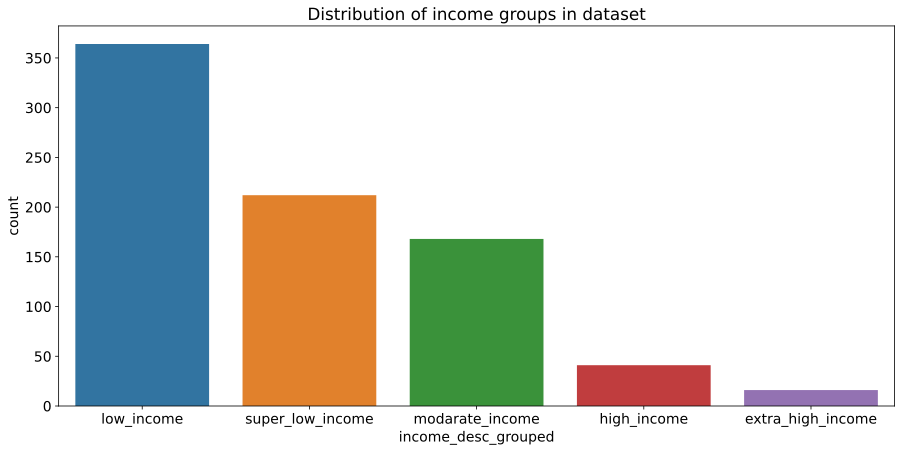

In [261]:
plt.figure(figsize=(15, 7))

sns.countplot(x='income_desc_grouped', data=user_features)
plt.title('Distribution of income groups in dataset')

plt.show()

В основном покупатели обладают очень низким и низким доходом, они составляют около 2/3 всего датасета.

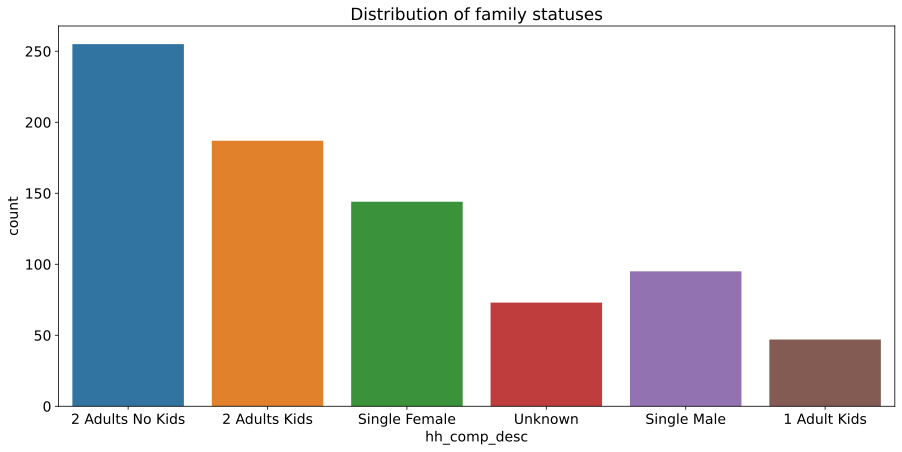

In [262]:
plt.figure(figsize=(15, 7))

sns.countplot(x='hh_comp_desc', data=user_features)
plt.title('Distribution of family statuses')

plt.show()

Покупают в этом магазине в основном полные семьи без детей и с детьми.

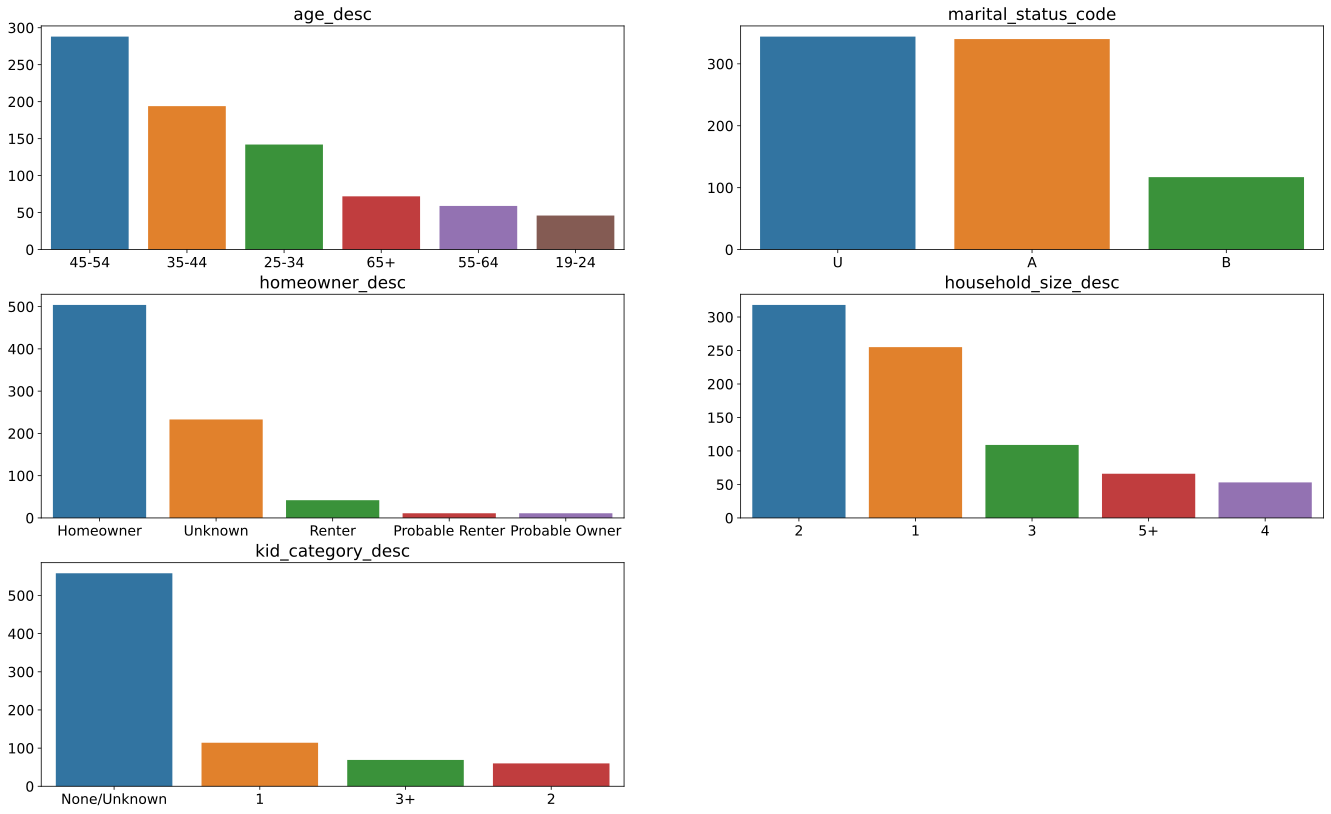

In [263]:
user_features_bin_features = user_features[['age_desc', 'marital_status_code', 'homeowner_desc', 'household_size_desc', 'kid_category_desc']]
plt.figure(figsize = (23,14))

for i, colname in enumerate(user_features_bin_features.columns, start=1):
    counts = user_features_bin_features[colname].value_counts()
    # normalize=True - для доли
    
    plt.subplot(3,2,i)    
    plt.title(colname)
    sns.barplot(counts.index, counts.values)
    
plt.show()

По возрасту преобладают категории 35-54.

Далее объединим данные, что построить более интересные графики.

In [264]:
data_merged = pd.merge(data, item_features[['item_id', 'department', 'commodity_desc']], how='left', on="item_id")
data_merged = pd.merge(data_merged, user_features, how='left', on="user_id")
data_merged.tail(6)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,department,commodity_desc,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,income_desc_grouped
2396798,1613,41655820646,663,15712538,1,2.99,3262,-0.16,1231,95,0.0,0.0,GROCERY,YOGURT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2396799,1613,41655820646,663,16102849,1,2.00,3262,-1.15,1231,95,0.0,0.0,GROCERY,FRZN MEAT/MEAT DINNERS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2396800,1001,41655829421,663,13217063,1,1.69,3131,0.00,2231,95,0.0,0.0,GROCERY,ICE CREAM/MILK/SHERBTS,45-54,U,50-74K,Homeowner,Unknown,1,None/Unknown,low_income
2396801,1001,41655829421,663,13217800,1,1.69,3131,0.00,2231,95,0.0,0.0,GROCERY,ICE CREAM/MILK/SHERBTS,45-54,U,50-74K,Homeowner,Unknown,1,None/Unknown,low_income
2396802,1167,41656790510,663,6410462,22451,43.98,3385,-0.65,1059,95,0.0,0.0,KIOSK-GAS,COUPON/MISC ITEMS,35-44,U,50-74K,Homeowner,2 Adults Kids,4,2,low_income
2396803,1167,41656790510,663,6430664,1,8.00,3385,0.00,1059,95,0.0,0.0,MISC SALES TRAN,COUPON/MISC ITEMS,35-44,U,50-74K,Homeowner,2 Adults Kids,4,2,low_income


In [265]:
dept_pop_by_income = data_merged.groupby(['income_desc_grouped', 'commodity_desc'], as_index=False).agg({'quantity':'sum'})\
                       .rename(columns={'quantity':'purchases_count_in_dept'})

In [266]:
dept_pop_by_income = dept_pop_by_income.sort_values(['income_desc_grouped','purchases_count_in_dept'],ascending=False).groupby('income_desc_grouped').head(5)
dept_pop_by_income

,income_desc_grouped,commodity_desc,purchases_count_in_dept
1257,super_low_income,COUPON/MISC ITEMS,27131593
1446,super_low_income,SOFT DRINKS,25662
1302,super_low_income,FLUID MILK PRODUCTS,13552
1317,super_low_income,FRZN MEAT/MEAT DINNERS,13418
1196,super_low_income,BAKED BREAD/BUNS/ROLLS,12240
958,modarate_income,COUPON/MISC ITEMS,41948500
1147,modarate_income,SOFT DRINKS,16250
1003,modarate_income,FLUID MILK PRODUCTS,13833
1180,modarate_income,YOGURT,11763
932,modarate_income,CHEESE,11110


Можно обратить внимание, что у более деных категорий в топ-5 по покупкам присутствует хлеб и готовые обеды. В то же время с ростом дохода в "корзине" больше покупок сыра, йогуртов.

In [267]:
dept_pop_by_income_purchases_sum = data_merged.groupby(['income_desc_grouped', 'commodity_desc'], as_index=False).agg({'sales_value':'sum'})\
                       .rename(columns={'sales_value':'purchases_sum_in_dept'})

In [268]:
dept_pop_by_income_purchases_sum.sort_values(['income_desc_grouped','purchases_sum_in_dept'],ascending=False).groupby('income_desc_grouped').head()

,income_desc_grouped,commodity_desc,purchases_sum_in_dept
1257,super_low_income,COUPON/MISC ITEMS,67790.27
1446,super_low_income,SOFT DRINKS,48505.99
1206,super_low_income,BEEF,44156.42
1317,super_low_income,FRZN MEAT/MEAT DINNERS,24243.94
1302,super_low_income,FLUID MILK PRODUCTS,23047.52
958,modarate_income,COUPON/MISC ITEMS,105784.22
1147,modarate_income,SOFT DRINKS,35042.03
906,modarate_income,BEEF,30354.21
1003,modarate_income,FLUID MILK PRODUCTS,25112.34
932,modarate_income,CHEESE,22170.99


Если отсортировать по сумме затрат, то в наиболее обеспеченных сегментах появляется, естесственно, винишко.

### LightFM

У этого алогритма есть множество параметров (item/user_alpha, loss, no_components).  
Проведите эксперименты аналогично дз 3 (подберите гипперпараметры каким удобно способои и постройте графики)  
На выходе необходимо получить pr@5 на валидации (последние 3 недели) > 17%  

У Вас, скорее всего, возникнет проблема со временем обучения. Почему они возникает?    

Попробуйте запустить алгоритм вообще без фичей или используйте только признаки с небольшим числом уникальных категорий. (item_features['commodity_desc'].unique() - 300 уникальных категорий - это очень много)

#### Prepare data set

In [269]:
n_items_before = data_train['item_id'].nunique()

data_train = prefilter_items(data_train, item_features)

n_items_after = data_train['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 86865 to 2690


In [270]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
#data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999 - уже сделано в src

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(2)

item_id,202291,420647,545926,707683,819063,819227,819255,819304,819308,819330,819518,819594,819765,819840,819845,819927,819978,820082,820122,820165,820301,820321,820486,820518,820701,821025,821083,821209,821562,821735,821976,822049,822140,822241,822346,822407,822517,822524,822739,822936,823176,823356,823704,823775,823862,823990,824005,824037,824073,824180,824193,824311,824555,824758,824796,824915,825006,825343,825365,825541,825618,825703,825731,825749,825882,825970,825994,826144,826249,826272,826666,826952,827180,827261,827570,827656,827667,827671,827683,827802,827919,827999,828106,828143,828328,828331,828891,828935,829001,829291,829323,829621,829645,829722,829852,830156,830304,830503,830568,830582,830750,830795,830887,831063,831390,831517,831536,831557,831628,831712,831763,831808,831888,831937,832288,832335,832442,832678,832976,833351,833458,833556,833598,833724,833754,833940,834117,834158,834382,834484,834826,834932,835004,835098,835278,835279,835285,835300,835530,835578,835595,835618,835619,835973,836286,836445,836891,837012,837107,837139,837270,837304,837339,837644,837865,838186,838602,838797,839147,839162,839208,839238,839243,839346,839419,839656,840011,840227,840361,840609,840890,841220,841266,841309,841365,841762,842125,842140,842455,842707,843111,843171,843259,843306,843346,843450,843464,843689,843744,843756,844023,844054,844165,844179,844462,844697,844740,844818,844839,844991,845109,845193,845208,845265,845294,845307,845319,845622,845675,845705,845774,846241,846334,846417,846550,846634,846823,846833,846986,847066,847127,847139,847207,847241,847270,847344,847573,847789,847790,848029,848319,848631,848970,849003,849018,849100,849202,849297,849315,849505,849578,849843,849870,850058,850102,850133,850157,850529,850562,850645,...,8293343,8293385,8293439,8293447,8357613,9187298,9242918,9245106,9245108,9245413,9245417,9245462,9268695,9270757,9296804,9296837,9296919,9296965,9297136,9297177,9297403,9297474,9297615,9333734,9337369,9337581,9338009,9362429,9365106,9392700,9396705,9396750,9396770,9416729,9419470,9419525,9420021,9420067,9420286,9420312,9420336,9469110,9487534,9487727,9487885,9523058,9523079,9524291,9526254,9526313,9526410,9526411,9526430,9526563,9526628,9526630,9526666,9526673,9526892,9527159,9527184,9527257,9527290,9527323,9527350,9527487,9527494,9546982,9553042,9553048,9553288,9553335,9553382,9553397,9571047,9575582,9653714,9655212,9655528,9670830,9676866,9677202,9677236,9677366,9677886,9705473,9707137,9707240,9707498,9802914,9802981,9803545,9803601,9832070,9832469,9833277,9835223,9835408,9835509,9835606,9835619,9835903,9835947,9836106,9836460,9836526,9837076,9837807,9858742,9858794,9858936,9859052,9859060,9859111,9859112,9859128,9859182,9859183,9878513,9881592,9881593,9884698,9913338,9926758,9934800,9935616,10121610,10121965,10149597,10149640,10150194,10180324,10198378,10282046,10284946,10284966,10285006,10285106,10285141,10285144,10285149,10285187,10344585,10344586,10344971,10351524,10355978,10455579,10455984,10456152,10456371,10456568,10457044,10457233,10457532,12132685,12172240,12172355,12185235,12188126,12188583,12188584,12262778,12262830,12262978,12262992,12263464,12263604,12263692,12263788,12301073,12301100,12301109,12301405,12301839,12302069,12324841,12324954,12326050,12330794,12349795,12352293,12384365,12384431,12384775,12384779,12425418,12428017,12428436,12524510,12577242,12648296,12670071,12673243,12695224,12731306,12731432,12731436,12731484,12731544,12731685,12731714,12754036,12757316,12781986,12782182,12810389,12810391,12810393,12810422,12810464,12811532,12812261,12946027,12949590,12949855,12987975,12988031,13003092,13008334,13071902,13072850,13095132,13095134,13115493,13115501,13115548,13115937,13189726,13210025,13381584,13416351,13506200,13511457,13511722,13512965,13672065,13841744,13877192,13987135,14077333,14106445,15452677,15596488,15596515,15831255,15926844,15926886,15927403,15927850
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [271]:
#data_test = data_test[data_test['item_id'].isin(data_train['item_id'].unique())]
test_user_item_matrix = pd.pivot_table(data_test, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

test_user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

In [272]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [273]:
user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(user_features, on='user_id', how='left').drop(columns=['homeowner_desc', 'income_desc_grouped'])
user_feat.set_index('user_id', inplace=True)

item_feat = pd.DataFrame(user_item_matrix.columns)
item_feat = item_feat.merge(item_features, on='item_id', how='left').drop(columns=['sub_commodity_desc', 'curr_size_of_product'])
item_feat.set_index('item_id', inplace=True)

user_feat.head(2)

,age_desc,marital_status_code,income_desc,hh_comp_desc,household_size_desc,kid_category_desc
user_id,,,,,,
1,65+,A,35-49K,2 Adults No Kids,2,None/Unknown
2,NaN,NaN,NaN,NaN,NaN,NaN


In [274]:
user_feat_lightfm_fixed = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())
item_feat_lightfm_fixed = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())

#### Compare models

Протестируем, что всё работает и подгоним время для теста

In [275]:
%%time

model = LightFM(no_components=64,
                loss='warp', # или 'warp' - ниже в уроке описана разница
                learning_rate=0.05, 
                item_alpha=0.0, user_alpha=0.0, 
                random_state=42)

CPU times: user 690 µs, sys: 0 ns, total: 690 µs
Wall time: 700 µs


In [276]:
%%time

model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
                          sample_weight=coo_matrix(user_item_matrix),  # матрица весов С
                          user_features=csr_matrix(user_feat_lightfm_fixed.values).tocsr(),
                          item_features=csr_matrix(item_feat_lightfm_fixed.values).tocsr(),
                          epochs=15, 
                          num_threads=8) 

CPU times: user 5.73 s, sys: 5.97 ms, total: 5.73 s
Wall time: 3.03 s


In [277]:
%%time

precision = pr(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm_fixed.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm_fixed.values).tocsr(),
                                 k=5).mean()
print(precision)

0.31516612
CPU times: user 2.55 s, sys: 0 ns, total: 2.55 s
Wall time: 2.56 s


In [278]:
%%time

no_components_list = [10, 16, 32, 64] # Число эмбеддингов
loss_list = ['bpr', 'warp']
item_alpha_list = [0.05, 0.1, 0.2]
user_alpha_list = [0.05, 0.1, 0.2]
grid = []

for components in no_components_list:
    for loss in loss_list:
        for item_alpha in item_alpha_list:
            for user_alpha in user_alpha_list:
                grid_row = []
                grid_row.append(components)
                grid_row.append(loss)
                grid_row.append(item_alpha)
                grid_row.append(user_alpha)

                model = LightFM(no_components=components,
                                loss=loss, # или 'warp' - ниже в уроке описана разница
                                learning_rate=0.05, 
                                item_alpha=item_alpha, user_alpha=user_alpha, 
                                random_state=42)

                model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
                          sample_weight=coo_matrix(user_item_matrix),  # матрица весов С
                          user_features=csr_matrix(user_feat_lightfm_fixed.values).tocsr(),
                          item_features=csr_matrix(item_feat_lightfm_fixed.values).tocsr(),
                          epochs=15, 
                          num_threads=8) 
                
                precision = pr(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm_fixed.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm_fixed.values).tocsr(),
                                 k=5).mean()

                grid_row.append(precision)
                grid.append(grid_row)

CPU times: user 5min 28s, sys: 295 ms, total: 5min 28s
Wall time: 3min 41s


In [279]:
for row in sorted(grid, key=lambda x: x[4], reverse=True):
    print(f'no_components: {row[0]}, loss: {row[1]}, item_alpha: {row[2]}, user_alpha: {row[3]}, precision: {row[4]}')

no_components: 32, loss: warp, item_alpha: 0.2, user_alpha: 0.05, precision: 0.3076430857181549
no_components: 64, loss: warp, item_alpha: 0.2, user_alpha: 0.05, precision: 0.2960384488105774
no_components: 10, loss: warp, item_alpha: 0.2, user_alpha: 0.05, precision: 0.28539419174194336
no_components: 16, loss: warp, item_alpha: 0.2, user_alpha: 0.05, precision: 0.28539419174194336
no_components: 10, loss: warp, item_alpha: 0.05, user_alpha: 0.05, precision: 0.1863945722579956
no_components: 10, loss: warp, item_alpha: 0.05, user_alpha: 0.1, precision: 0.1771908849477768
no_components: 32, loss: bpr, item_alpha: 0.2, user_alpha: 0.05, precision: 0.1470988392829895
no_components: 16, loss: bpr, item_alpha: 0.2, user_alpha: 0.2, precision: 0.14701882004737854
no_components: 32, loss: bpr, item_alpha: 0.05, user_alpha: 0.1, precision: 0.1463785618543625
no_components: 32, loss: bpr, item_alpha: 0.1, user_alpha: 0.2, precision: 0.14589835703372955
no_components: 32, loss: bpr, item_alpha:

С точностью до 16-ого знака одинаковый результат precision = 0.3076 показали модели с парметрами: 
* no_components: 16 / 32
* loss: warp
* item_alpha: 0.2
* user_alpha: 0.05

Обратил внимание, что только модели, использующие WARP в качестве loss'а смогли пробить значение precision больше 17. При этом, кроме loss, решающее значение сыграли и параметры регуляризации user и item, т.к. они забрали все первые места. В этом кейсе подбор значения no_components дал всего 2-4% к результату.

### *Отбор признаков* * 

Все данные категориальные, при ohe (one-hot encoding) кодировании для товаров признаков становится невероятно много.      
Какие стратегии отбора признаков в классическом ML Вы знаете? Применимы ли они тут?  

Попробйте какие-нибудь стратегии. Удалось ли улучшить качество?

 \* *задание необязательно*
